## Multi-CNN Functional Model on PSG Sleep Data
Author: Tyler Lynn, Lee Hinkle


---


Contributor(s): 


---


Credit to Lee Hinkle for data and code inspiraiton.

```
PSG-Audio data
Saved to /content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_9ch_10sub
Generated by PSG-Audio_load_dataset.ipynb on Oct-03-2022_2129this version for fusion of learned representation work
contains data from first 9 sensors and 10 subs
1st 3 subs to train, next to validate and test, repeat
This needs work in PSG-Audio_load_dataset.ipynb

Time steps =500, Step =500, no resample
Final Shapes
X shape (26687, 500, 9) dtype = float32
y shape (26687, 1) dtype = int8
sub shape (26687, 1) dtype = uint16
Channel names:['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']
Final Label Counts
[[    0 22964]
 [    1  1392]
 [    2    45]
 [    3    98]
 [    4  2188]]
Samples per Subject
[[ 995 3129]
 [ 999 2802]
 [1000 2546]
 [1006 2643]
 [1008 2558]
 [1010 1970]
 [1014 2184]
 [1016 3912]
 [1018 2324]
 [1020 2619]]
Generated by PSG-Audio_load_dataset.ipynb
October 03, 2022
sub dict = {'train_subj': [995, 999, 1000, 1010, 1014, 1016], 'valid_subj': [1006, 1018], 'test_subj': [1008, 1020]}
Initial Array    shape            object type              data type
---------------  ---------------  -----------------------  -----------
X                (26687, 500, 9)  <class 'numpy.ndarray'>  float32
y                (26687, 1)       <class 'numpy.ndarray'>  int8
sub              (26687, 1)       <class 'numpy.ndarray'>  uint16
One Hot:{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

Returned Array    shape            object type              data type
----------------  ---------------  -----------------------  -----------
x_train:          (16543, 500, 9)  <class 'numpy.ndarray'>  float32
y_train:          (16543, 5)       <class 'numpy.ndarray'>  uint8
x_validation:     (4967, 500, 9)   <class 'numpy.ndarray'>  float32
y_validation:     (4967, 5)        <class 'numpy.ndarray'>  uint8
x_test:           (5177, 500, 9)   <class 'numpy.ndarray'>  float32
y_test:           (5177, 5)        <class 'numpy.ndarray'>  uint8
```




In [ ]:
save_log = True;  # set to True and mount drive to save result files
if save_log:
    log_dir = '/content/drive/MyDrive/Colab_Run_Results'

In [ ]:
my_dir = '.'
interactive = True # run simple call on each cell, or use False + run all
verbose = True

In [ ]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import urllib.request # to get files from web w/o !wget
home_dir = os.getcwd()

channel_names = ['EEG A1-A2', 'EEG C3-A2', 'EEG C4-A1', 'EOG LOC-A2', 'EOG ROC-A2', 'EMG Chin', 'Leg 1', 'Leg 2', 'ECG I']

Need to upload the PSG NP arrays into the colab session

In [ ]:
#I refer to the file I stored the NP-arrays in as "PSG" in my google drive
#simple function for retrieving all arrays 
def get_np_arrays():
    path  = os.path.join(home_dir,'drive','MyDrive','Colab Notebooks','PSG', '50_allchannels')
    x_train = np.load(os.path.join(path, 'x_train.npy'))
    y_train = np.load(os.path.join(path, 'y_train.npy'))
    x_test= np.load(os.path.join(path, 'x_test.npy'))
    y_test = np.load(os.path.join(path, 'y_test.npy'))
    x_valid = np.load(os.path.join(path, 'x_valid.npy'))
    y_valid = np.load(os.path.join(path, 'y_valid.npy'))
    return x_train, y_train, x_test, y_test, x_valid, y_valid

x_train, y_train, x_test, y_test, x_valid, y_valid = get_np_arrays()
print("Before Balancing")
headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_valid:", x_valid.shape, x_valid.dtype),
        ("y_valid:", y_valid.shape, y_valid.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))



Before Balancing

 Array     shape             data type
--------  ----------------  -----------
x_train:  (41469, 500, 12)  float32
y_train:  (41469, 2)        uint8
x_valid:  (15854, 500, 12)  float32
y_valid:  (15854, 2)        uint8
x_test:   (27959, 500, 12)  float32
y_test:   (27959, 2)        uint8


In [ ]:
#Channel_names 
#['EEG A1-A2': eeg_1 , 'EEG C3-A2' : eeg_2 , 'EEG C4-A1' : eeg_3 , 'EOG LOC-A2' : eog_1 , 'EOG ROC-A2' : eog_2 , 'EMG Chin' : emg , 
#  'Leg 1' : leg_1 , 'Leg 2' : leg_2 , 'ECG I' : ecg]
#split data by sensor and by individual
all_channels = False
binary = False

#crude way of making th
def two_state_label(y_array):
    samples = y_array.shape[0]
    #https://www.delftstack.com/howto/numpy/python-compare-arrays/
    for sample in range(samples):
        if not np.array_equiv([1,0,0,0], y_array[sample]):
            y_array[sample] =[0,1,0,0]
    return y_array

def two_state_all(y_train, y_test, y_valid):
    y_train = two_state_label(y_train)
    y_test = two_state_label(y_test)
    y_valid = two_state_label(y_valid)  
    return y_train, y_test, y_valid  

def split_by_channel(array):
    split_arr = np.array_split(array, 9, axis = 2)
    eeg_1 = split_arr[0]
    eeg_2 = split_arr[1]
    eeg_3 = split_arr[2]
    eog_1 = split_arr[3]
    eog_2 = split_arr[4]
    emg  = split_arr[5]
    leg_1 = split_arr[6]
    leg_2 = split_arr[7]
    ecg =  split_arr[8]
    return eeg_1, eeg_2, eeg_3, eog_1, eog_2, emg, leg_1, leg_2, ecg


def split_by_sensor(array):
    #there is definitely a better way to do this 
    #but I do only know how to delete
    eeg = np.delete(array, [3,4,5,6,7,8],2)
    eog = np.delete(array, [0,1,2,5,6,7,8],2)
    emg = np.delete(array, [0,1,2,3,4,6,7,8],2)
    #I dont know if its smarter to bundle the legs or keep them seperate, but here I am going to bundle them
    legs = np.delete(array, [0,1,2,3,4,5,8],2)
    ecg = np.delete(array, [0,1,2,3,4,5,6,7],2)
    return eeg, eog, emg, legs, ecg

#all channels is set to true at the top cell. Change it if you want to split by sensor.
headers = ["array", "Orig shape"] 
if all_channels: 
    x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg  = split_by_channel(x_train)
    x_test_eeg_1, x_test_eeg_2, x_test_eeg_3, x_test_eog_1, x_test_eog_2, x_test_emg, x_test_leg_1, x_test_leg_2, x_test_ecg = split_by_channel(x_test)
    x_valid_eeg_1, x_valid_eeg_2, x_valid_eeg_3, x_valid_eog_1, x_valid_eog_2, x_valid_emg, x_valid_leg_1, x_valid_leg_2, x_valid_ecg = split_by_channel(x_valid) 
    headers.extend(channel_names)
else:
    x_train_eeg, x_train_eog, x_train_emg, x_train_legs, x_train_ecg = split_by_sensor(x_train)
    x_test_eeg, x_test_eog, x_test_emg, x_test_legs, x_test_ecg = split_by_sensor(x_test)
    x_valid_eeg, x_valid_eog, x_valid_emg, x_valid_legs, x_valid_ecg = split_by_sensor(x_valid)
    headers.extend(['EEG','EOG','EMG','LEGS','ECG'])

if binary:
    y_train, y_test, y_valid = two_state_all(y_train, y_test, y_valid)

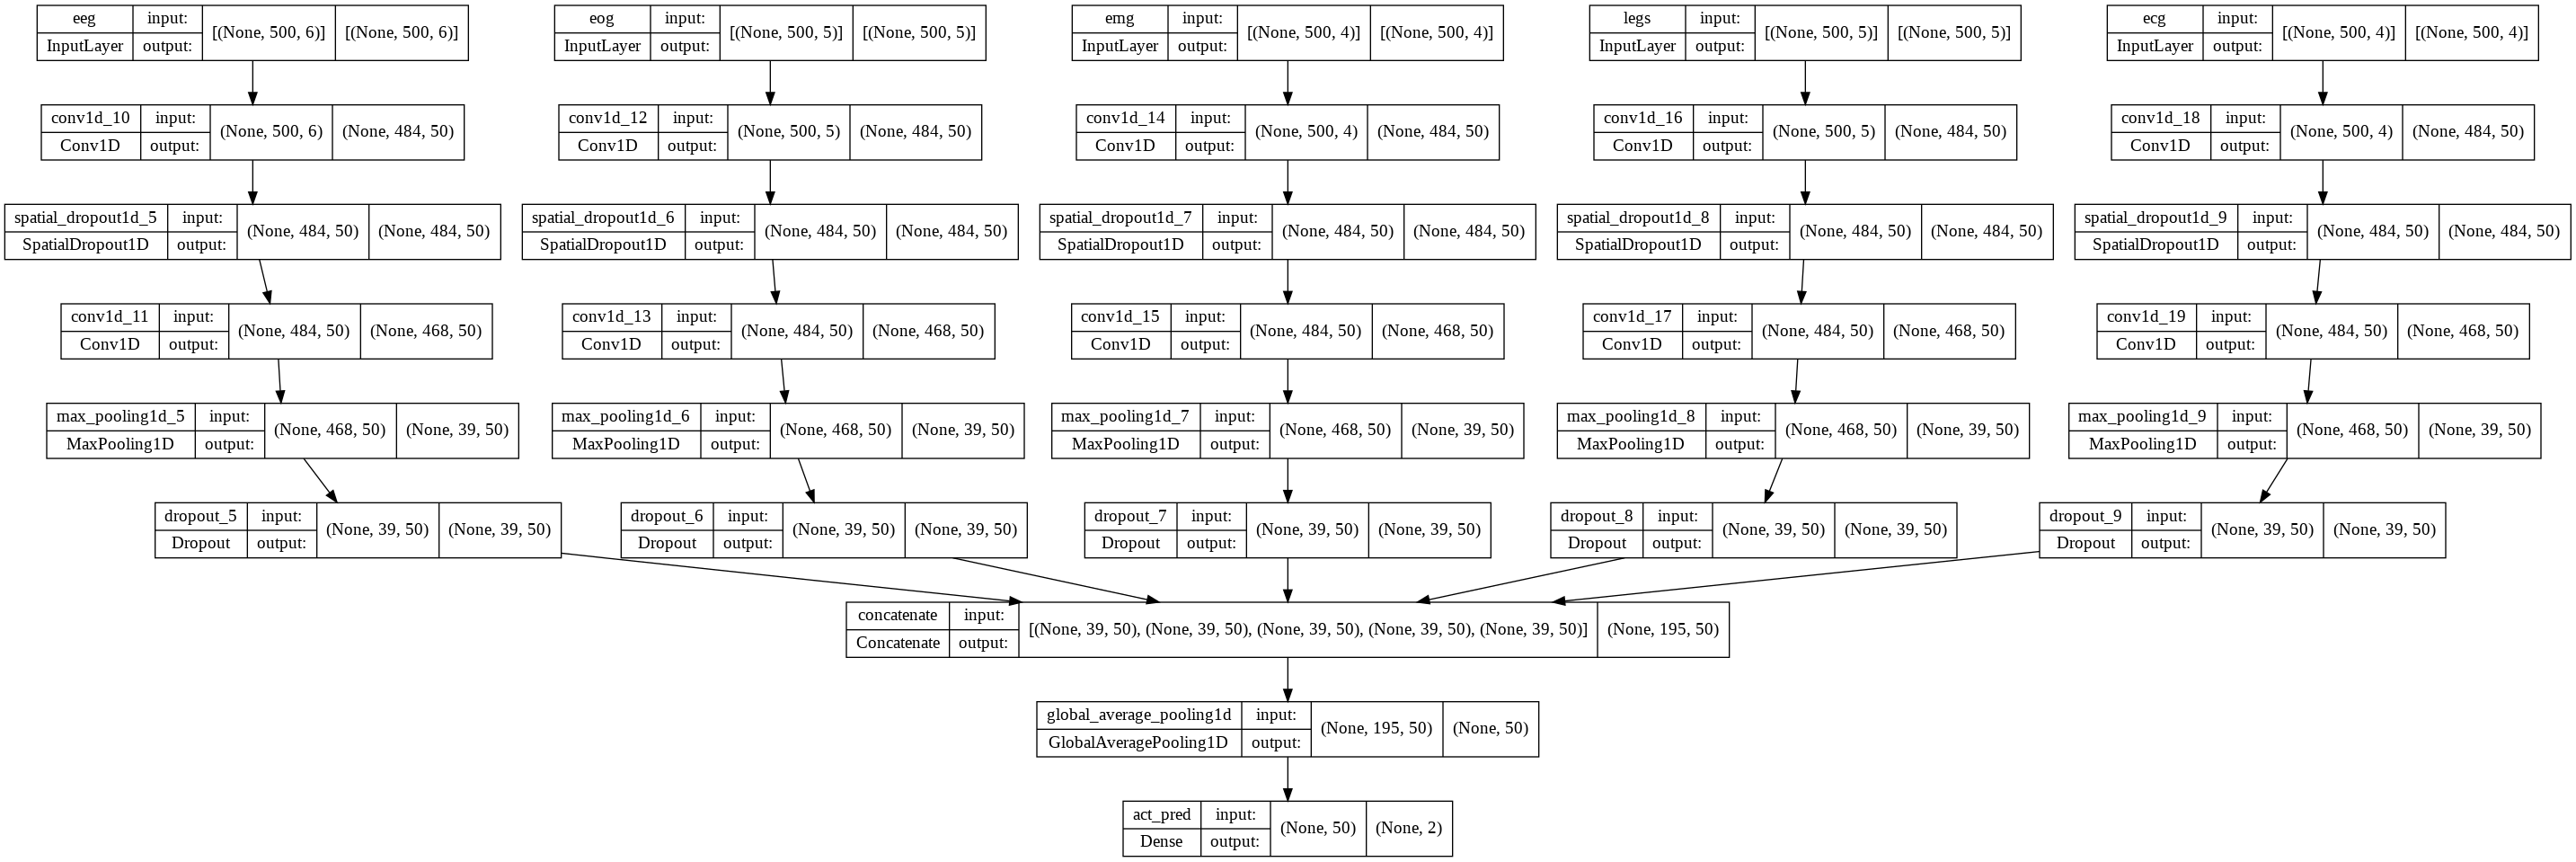

In [ ]:
"""
def get_CNN_model(array, kernel_s, drop_r,  n):
    inputs = keras.Input(shape =(array.shape[1], array.shape[2]), name = n)
    x = layers.Conv1D(filters = 50, kernel_size = kernel_s, activation = 'relu')(inputs)
    x = layers.SpatialDropout1D(0.25)(x)
    x = layers.Conv1D(filters = 50, kernel_size = kernel_s, activation = 'relu')(x)
    x = layers.MaxPooling1D(pool_size = 12)(x)
    outputs = layers.Dropout(drop_r)(x)
    return keras.Model(inputs, outputs)

#make the output of model1 the input to model2
#vertically link together into one model
def link(model1, model2):
    pass

def ensemble(models):
    merged = layers.Concatenate(axis=1)(models)
    merged = layers.GlobalAveragePooling1D()(merged)
    return merged

def finalize():
    pass


#this version is having huge issues
def per_channel_model(x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg, y_train):
    n_outputs = y_train.shape[1]
    eeg_1_input = keras.Input(shape =(x_train_eeg_1.shape[1], x_train_eeg_1.shape[2]), name = channel_names[0])
    eeg_2_input = keras.Input(shape =(x_train_eeg_2.shape[1], x_train_eeg_2.shape[2]), name = channel_names[1])
    eeg_3_input = keras.Input(shape =(x_train_eeg_3.shape[1], x_train_eeg_3.shape[2]), name = channel_names[2])
    eog_1_input = keras.Input(shape =(x_train_eog_1.shape[1], x_train_eog_1.shape[2]), name = channel_names[3])
    eog_2_input = keras.Input(shape =(x_train_eog_2.shape[1], x_train_eog_2.shape[2]), name = channel_names[4])
    emg_input = keras.Input(shape =(x_train_emg.shape[1], x_train_emg.shape[2]), name = channel_names[5])
    leg_1_input = keras.Input(shape =(x_train_leg_1.shape[1], x_train_leg_1.shape[2]), name = channel_names[6])
    leg_2_input = keras.Input(shape =(x_train_leg_2.shape[1], x_train_leg_2.shape[2]), name = channel_names[7])
    ecg_input = keras.Input(shape =(x_train_ecg.shape[1], x_train_ecg.shape[2]), name = channel_names[8])

    eeg_1_model = get_CNN_model(x_train_eeg_1, 17, 0.25, channel_names[0])
    eeg_2_model = get_CNN_model(x_train_eeg_2, 17, 0.25, channel_names[1])
    eeg_3_model = get_CNN_model(x_train_eeg_3, 17, 0.25, channel_names[2])
    eog_1_model = get_CNN_model(x_train_eog_1, 17, 0.25, channel_names[3])
    eog_2_model = get_CNN_model(x_train_eog_2, 17, 0.25, channel_names[4])
    emg_0_model = get_CNN_model(x_train_emg, 17, 0.25, channel_names[5])
    leg_1_model = get_CNN_model(x_train_leg_1, 17, 0.25, channel_names[6])
    leg_2_model = get_CNN_model(x_train_leg_2, 17, 0.25, channel_names[7])
    ecg_model = get_CNN_model(x_train_ecg, 17, 0.25, channel_names[8])

    eeg_1 = eeg_1_model(eeg_1_input)
    eeg_2 = eeg_2_model(eeg_2_input)
    eeg_3 = eeg_3_model(eeg_3_input)
    eog_1 = eog_1_model(eog_1_input)
    eog_2 = eog_2_model(eog_2_input)
    emg_0 = emg_0_model(emg_input)
    leg_1 = leg_1_model(leg_1_input)
    leg_2 = leg_2_model(leg_2_input)
    ecg = ecg_model(ecg_input)


    merged = layers.Concatenate(axis=1)([eeg_1, eeg_2, eeg_3, eog_1, eog_2, emg_0, leg_1, leg_2, ecg])
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation = 'softmax', name = 'act_pred')(merged)

    model = keras.Model(
        inputs=[eeg_1_input, eeg_2_input, eeg_3_input, eog_1_input, eog_2_input, emg_input, leg_1_input, leg_2_input, ecg_input],
        outputs=[pred],
    )
    return model

model = per_channel_model(x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg, y_train)


def per_channel_model(training, )

n_outputs = y_train.shape[1]
x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg  = split_by_channel(x_train)
eeg_1_input = keras.Input(shape =(x_train_eeg_1.shape[1], x_train_eeg_1.shape[2]), name = channel_names[0])
eeg_2_input = keras.Input(shape =(x_train_eeg_2.shape[1], x_train_eeg_2.shape[2]), name = channel_names[1])
eeg_3_input = keras.Input(shape =(x_train_eeg_3.shape[1], x_train_eeg_3.shape[2]), name = channel_names[2])
model1 = get_CNN_model(x_train_eeg_1, 17, 0.25, "EEG1")
model2 = get_CNN_model(x_train_eeg_2, 17, 0.25,"EEG2")
model3 = get_CNN_model(x_train_eeg_3, 17, 0.25, "EEG3")

x= model1(eeg_1_input)
y= model2(eeg_2_input)
z = model3(eeg_3_input)

merged = layers.Concatenate(axis=1)([x, y, z])
merged = layers.GlobalAveragePooling1D()(merged)
pred = layers.Dense(n_outputs, activation = 'softmax', name = 'act_pred')(merged)

model = keras.Model(
    inputs = [eeg_1_input, eeg_2_input, eeg_3_input],
    outputs = [pred],
)
display(keras.utils.plot_model(model, "CNN_.png", show_shapes = True))




model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)


"""



def per_channel_model(x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg):
    #seperate inputs for every channel
    n_outputs = y_train.shape[1]
    eeg_1_input = keras.Input(shape =(x_train_eeg_1.shape[1], x_train_eeg_1.shape[2]), name = channel_names[0])
    eeg_2_input = keras.Input(shape =(x_train_eeg_2.shape[1], x_train_eeg_2.shape[2]), name = channel_names[1])
    eeg_3_input = keras.Input(shape =(x_train_eeg_3.shape[1], x_train_eeg_3.shape[2]), name = channel_names[2])
    eog_1_input = keras.Input(shape =(x_train_eog_1.shape[1], x_train_eog_1.shape[2]), name = channel_names[3])
    eog_2_input = keras.Input(shape =(x_train_eog_2.shape[1], x_train_eog_2.shape[2]), name = channel_names[4])
    emg_input = keras.Input(shape =(x_train_emg.shape[1], x_train_emg.shape[2]), name = channel_names[5])
    leg_1_input = keras.Input(shape =(x_train_leg_1.shape[1], x_train_leg_1.shape[2]), name = channel_names[6])
    leg_2_input = keras.Input(shape =(x_train_leg_2.shape[1], x_train_leg_2.shape[2]), name = channel_names[7])
    ecg_input = keras.Input(shape =(x_train_ecg.shape[1], x_train_ecg.shape[2]), name = channel_names[8])

    #place all channels into models of this structure
    eeg_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_1_input)
    eeg_1 = layers.SpatialDropout1D(0.25)(eeg_1)
    eeg_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_1)
    eeg_1 = layers.MaxPooling1D(pool_size = 12)(eeg_1)
    eeg_1 = layers.Dropout(0.25)(eeg_1)

    eeg_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_2_input)
    eeg_2 = layers.SpatialDropout1D(0.25)(eeg_2)
    eeg_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_2)
    eeg_2 = layers.MaxPooling1D(pool_size = 12)(eeg_2)
    eeg_2 = layers.Dropout(0.25)(eeg_2)

    eeg_3 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_3_input)
    eeg_3 = layers.SpatialDropout1D(0.25)(eeg_3)
    eeg_3 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_3)
    eeg_3 = layers.MaxPooling1D(pool_size = 12)(eeg_3)
    eeg_3 = layers.Dropout(0.25)(eeg_3)


    eog_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_1_input)
    eog_1 = layers.SpatialDropout1D(0.25)(eog_1)
    eog_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_1)
    eog_1 = layers.MaxPooling1D(pool_size = 12)(eog_1)
    eog_1 = layers.Dropout(0.25)(eog_1)


    eog_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_2_input)
    eog_2 = layers.SpatialDropout1D(0.25)(eog_2)
    eog_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_2)
    eog_2 = layers.MaxPooling1D(pool_size = 12)(eog_2)
    eog_2 = layers.Dropout(0.25)(eog_2)


    emg_0 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg_input)
    emg_0 = layers.SpatialDropout1D(0.25)(emg_0)
    emg_0 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg_0)
    emg_0 = layers.MaxPooling1D(pool_size = 12)(emg_0)
    emg_0 = layers.Dropout(0.25)(emg_0)


    leg_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(leg_1_input)
    leg_1 = layers.SpatialDropout1D(0.25)(leg_1)
    leg_1 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(leg_1)
    leg_1 = layers.MaxPooling1D(pool_size = 12)(leg_1)
    leg_1 = layers.Dropout(0.25)(leg_1)


    leg_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(leg_2_input)
    leg_2 = layers.SpatialDropout1D(0.25)(leg_2)
    leg_2 = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(leg_2)
    leg_2 = layers.MaxPooling1D(pool_size = 12)(leg_2)
    leg_2 = layers.Dropout(0.25)(leg_2)


    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg_input)
    ecg = layers.SpatialDropout1D(0.25)(ecg)
    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg)
    ecg = layers.MaxPooling1D(pool_size = 12)(ecg)
    ecg = layers.Dropout(0.25)(ecg)

    merged = layers.Concatenate(axis=1)([eeg_1, eeg_2, eeg_3, eog_1, eog_2, emg_0, leg_1, leg_2, ecg])
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation = 'softmax', name = 'act_pred')(merged)

    model = keras.Model(
        inputs=[eeg_1_input, eeg_2_input, eeg_3_input, eog_1_input, eog_2_input, emg_input, leg_1_input, leg_2_input, ecg_input],
        outputs=[pred],
    )
    return model


def per_sensor_model(x_train_eeg, x_train_eog, x_train_emg, x_train_legs, x_train_ecg):
    n_outputs = y_train.shape[1]
    eeg_input = keras.Input(shape =(x_train_eeg.shape[1], x_train_eeg.shape[2]), name = "eeg")
    eog_input = keras.Input(shape =(x_train_eog.shape[1], x_train_eog.shape[2]), name = "eog")
    emg_input = keras.Input(shape =(x_train_emg.shape[1], x_train_emg.shape[2]), name = "emg")
    legs_input = keras.Input(shape =(x_train_legs.shape[1], x_train_legs.shape[2]), name = "legs")
    ecg_input = keras.Input(shape =(x_train_ecg.shape[1], x_train_ecg.shape[2]), name = "ecg")

    eeg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_input)
    eeg = layers.SpatialDropout1D(0.25)(eeg)
    eeg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg)
    eeg = layers.MaxPooling1D(pool_size = 12)(eeg)
    eeg = layers.Dropout(0.25)(eeg)

    eog = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_input)
    eog = layers.SpatialDropout1D(0.25)(eog)
    eog = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog)
    eog = layers.MaxPooling1D(pool_size = 12)(eog)
    eog = layers.Dropout(0.25)(eog)

    emg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg_input)
    emg = layers.SpatialDropout1D(0.25)(emg)
    emg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg)
    emg = layers.MaxPooling1D(pool_size = 12)(emg)
    emg = layers.Dropout(0.25)(emg)

    legs = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(legs_input)
    legs = layers.SpatialDropout1D(0.25)(legs)
    legs = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(legs)
    legs = layers.MaxPooling1D(pool_size = 12)(legs)
    legs = layers.Dropout(0.25)(legs)

    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg_input)
    ecg = layers.SpatialDropout1D(0.25)(ecg)
    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg)
    ecg = layers.MaxPooling1D(pool_size = 12)(ecg)
    ecg = layers.Dropout(0.25)(ecg)

    merged = layers.Concatenate(axis=1)([eeg,eog,emg,legs,ecg])
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation = 'softmax', name = 'act_pred')(merged)

    model = keras.Model(
        inputs = [eeg_input, eog_input, emg_input, legs_input, ecg_input],
        outputs = [pred],
    )

    return model

def per_sensor_model(x_train_eeg, x_train_eog, x_train_emg, x_train_legs, x_train_ecg):
    n_outputs = y_train.shape[1]
    eeg_input = keras.Input(shape =(x_train_eeg.shape[1], x_train_eeg.shape[2]), name = "eeg")
    eog_input = keras.Input(shape =(x_train_eog.shape[1], x_train_eog.shape[2]), name = "eog")
    emg_input = keras.Input(shape =(x_train_emg.shape[1], x_train_emg.shape[2]), name = "emg")
    legs_input = keras.Input(shape =(x_train_legs.shape[1], x_train_legs.shape[2]), name = "legs")
    ecg_input = keras.Input(shape =(x_train_ecg.shape[1], x_train_ecg.shape[2]), name = "ecg")

    eeg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg_input)
    eeg = layers.SpatialDropout1D(0.25)(eeg)
    eeg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eeg)
    eeg = layers.MaxPooling1D(pool_size = 12)(eeg)
    eeg = layers.Dropout(0.25)(eeg)

    eog = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog_input)
    eog = layers.SpatialDropout1D(0.25)(eog)
    eog = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(eog)
    eog = layers.MaxPooling1D(pool_size = 12)(eog)
    eog = layers.Dropout(0.25)(eog)

    emg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg_input)
    emg = layers.SpatialDropout1D(0.25)(emg)
    emg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(emg)
    emg = layers.MaxPooling1D(pool_size = 12)(emg)
    emg = layers.Dropout(0.25)(emg)

    legs = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(legs_input)
    legs = layers.SpatialDropout1D(0.25)(legs)
    legs = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(legs)
    legs = layers.MaxPooling1D(pool_size = 12)(legs)
    legs = layers.Dropout(0.25)(legs)

    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg_input)
    ecg = layers.SpatialDropout1D(0.25)(ecg)
    ecg = layers.Conv1D(filters = 50, kernel_size = 17, activation = 'relu')(ecg)
    ecg = layers.MaxPooling1D(pool_size = 12)(ecg)
    ecg = layers.Dropout(0.25)(ecg)

    merged = layers.Concatenate(axis=1)([eeg,eog,emg,legs,ecg])
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation = 'softmax', name = 'act_pred')(merged)

    model = keras.Model(
        inputs = [eeg_input, eog_input, emg_input, legs_input, ecg_input],
        outputs = [pred],
    )

    return model


if all_channels:
    model = per_channel_model(x_train_eeg_1, x_train_eeg_2, x_train_eeg_3, x_train_eog_1, x_train_eog_2, x_train_emg, x_train_leg_1, x_train_leg_2, x_train_ecg)
    display(keras.utils.plot_model(model, "per_channel_CNN_model.png", show_shapes = True))

    input_dict_train = {channel_names[0]:x_train_eeg_1, channel_names[1]:x_train_eeg_2, channel_names[2]:x_train_eeg_3, channel_names[3]:x_train_eog_1, 
                    channel_names[4]:x_train_eog_2, channel_names[5]:x_train_emg, channel_names[6]:x_train_leg_1, channel_names[7]:x_train_leg_2, 
                    channel_names[8]:x_train_ecg}
    input_dict_valid = {channel_names[0]:x_valid_eeg_1, channel_names[1]:x_valid_eeg_2, channel_names[2]:x_valid_eeg_3, channel_names[3]:x_valid_eog_1, 
                    channel_names[4]:x_valid_eog_2, channel_names[5]:x_valid_emg, channel_names[6]:x_valid_leg_1, channel_names[7]:x_valid_leg_2, 
                    channel_names[8]:x_valid_ecg}
    input_dict_test = {channel_names[0]:x_test_eeg_1, channel_names[1]:x_test_eeg_2, channel_names[2]:x_test_eeg_3, channel_names[3]:x_test_eog_1, 
                    channel_names[4]:x_test_eog_2, channel_names[5]:x_test_emg, channel_names[6]:x_test_leg_1, channel_names[7]:x_test_leg_2, 
                    channel_names[8]:x_test_ecg}


else:
    model = per_sensor_model(x_train_eeg, x_train_eog, x_train_emg, x_train_legs, x_train_ecg)
    display(keras.utils.plot_model(model, "per_sensor_CNN_model.png", show_shapes = True))

    input_names = ['eeg', 'eog', 'emg', 'legs', 'ecg']
    input_dict_train = {input_names[0]:x_train_eeg, input_names[1]:x_train_eog, input_names[2]:x_train_emg, input_names[3]:x_train_legs, input_names[4]:x_train_ecg} 
    input_dict_valid ={input_names[0]:x_valid_eeg, input_names[1]:x_valid_eog, input_names[2]:x_valid_emg, input_names[3]:x_valid_legs, input_names[4]:x_valid_ecg}
    input_dict_test ={input_names[0]:x_test_eeg, input_names[1]:x_test_eog, input_names[2]:x_test_emg, input_names[3]:x_test_legs, input_names[4]:x_test_ecg}

Epoch 1/100
1296/1296 [==============================] - 32s 17ms/step - loss: 0.4763 - accuracy: 0.8167 - val_loss: 0.3975 - val_accuracy: 0.8501
Epoch 2/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3444 - accuracy: 0.8509 - val_loss: 0.4377 - val_accuracy: 0.8345
Epoch 3/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3245 - accuracy: 0.8605 - val_loss: 0.4212 - val_accuracy: 0.8557
Epoch 4/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3145 - accuracy: 0.8654 - val_loss: 0.3923 - val_accuracy: 0.8576
Epoch 5/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.3038 - accuracy: 0.8680 - val_loss: 0.3753 - val_accuracy: 0.8617
Epoch 6/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.2956 - accuracy: 0.8732 - val_loss: 0.3875 - val_accuracy: 0.8596
Epoch 7/100
1296/1296 [==============================] - 21s 16ms/step - loss: 0.2908 - accuracy: 0.8763 - val_loss: 0

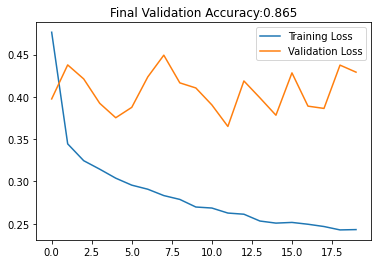

In [ ]:
def train_per_channel(model,
                      input_dict_train,
                      input_dict_valid, 
                      y_train,
                      y_valid,
                      BATCH_SIZE = 32, 
                      NUM_EPOCHS = 100):
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience =8)
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    history = model.fit(input_dict_train, {"act_pred":y_train},
                        epochs = NUM_EPOCHS,
                        callbacks = [callback],
                        validation_data = (input_dict_valid , y_valid),
                        verbose = 1)
    return history, model

def train_per_signal(model,
                     input_dict_train,
                     input_dict_valid,
                     y_train,
                     y_valid,
                     BATCH_SIZE = 32,
                     NUM_EPOCHS = 100):
    NUM_EPOCHS = 100
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=8)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(input_dict_train, 
                        {"act_pred": y_train},
                        epochs = NUM_EPOCHS,
                        callbacks = [callback],
                        validation_data = (input_dict_valid, y_valid),
                        verbose = 1)
    return history, model

if all_channels:
    history, model = train_per_channel(model,
                                       input_dict_train, 
                                       input_dict_valid, y_train, y_valid)
    print("Per Channel 1D CNN Functional Model")
    print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    plt.plot(history.history["loss"], label = "Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    #plt.ylim([0,2.5])
    plt.legend()
    plt.show()

else:
    history, model = train_per_signal(model, input_dict_train, input_dict_valid, y_train, y_valid)
    print(y_train.shape)
    print("Per Sensor 1D CNN Functional Model")
    plt.title('Final Validation Accuracy:{0:.3f}'.format(history.history['val_accuracy'][-1]))
    plt.plot(history.history["loss"], label = "Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    #plt.ylim([0,2.5]) I thought my model was broken and that I was an idiot, only one of those is true now
    plt.legend()
    plt.show()


Pretty clear that the accuracy of this model is being severely artificially inflated by the overrepresented normal samples. Also very weird that I am not seing a steads decline in the training loss and that the model is stagnant from the get go.

Both the per_channel_ model and the per_signal_ model did not perform well on the unfiltered data

Data needs to be improved by systematically removing a large chunk of the "normal" samples 

              precision    recall  f1-score   support

      normal       0.87      0.94      0.91     21788
  Resp Issue       0.72      0.51      0.60      6171

    accuracy                           0.85     27959
   macro avg       0.80      0.73      0.75     27959
weighted avg       0.84      0.85      0.84     27959



<function matplotlib.pyplot.show(*args, **kw)>

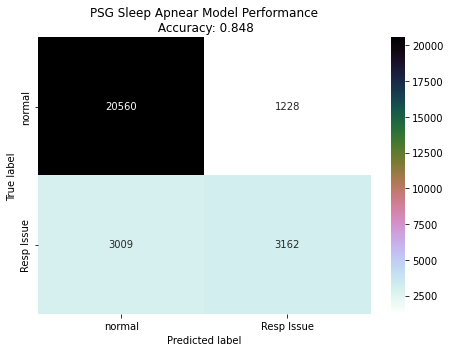

In [ ]:
#Running the other just to see the results
def run(model, x_test):
    predictions = model.predict(x_test, verbose = 0, batch_size = 32)
    y_pred = np.argmax(predictions, axis=-1)
    return y_pred

t_names = ['Normal', 'Respiratory Issue']

y_pred = run(model, input_dict_test)
y_test_act = np.argmax(y_test, axis=-1)
acc = accuracy_score(y_test_act, y_pred)
print(classification_report(y_test_act, y_pred, target_names = t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm, index = t_names, columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('PSG Sleep Apnear Model Performance\n Accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show

In [ ]:
#save log cell
#Will implement once model modularization and has been accomplished
